In [1]:
import torch 
import torch_geometric.transforms
import torch_geometric.data
from torch_geometric.data import Data, ClusterData, DataLoader
import numpy as np
import pickle
from torch.utils.data import random_split
import random
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, TopKPooling,GATConv, global_max_pool, global_mean_pool, global_add_pool
from torch_geometric.data import Batch
from torch_scatter import scatter_add
from torch.nn import Conv1d


In [4]:
#dataset = torch.load('graphs_stdc_dmixed.pt')

dataset = torch.load('../data/stdc/d5p05/graphs_clean.pt')
#dataset = torch.load('../data/stdc/dmixed_large/graphs_clean.pt')
#dataset = torch.load('../data/stdc/dmixed(579)_p1/graphs_clean.pt')
#dataset = torch.load('../data/stdc/d5p1/graphs_clean.pt')


batchsize=32
batch_train_splits = int(0.8*len(dataset)/batchsize)*batchsize
#batch_val_splits = int((len(dataset)-batch_train_splits)/batchsize)*batchsize
batch_test_splits = int(((len(dataset)-(batch_train_splits))/batchsize)*batchsize)

##print(batch_train_splits)
#print(batch_test_splits)
#print(batch_val_splits)


dataset_usage = len(dataset)-(batch_train_splits+batch_test_splits)

if dataset_usage ==0:
    train_dataset,test_dataset = random_split(dataset[:],[batch_train_splits, batch_test_splits],generator=torch.Generator().manual_seed(42))

else:
    train_dataset,test_dataset = random_split(dataset[:-dataset_usage],[batch_train_splits, batch_test_splits],generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
#print(len(val_loader))
print(len(test_loader))
print(len(train_loader))

30
113


In [5]:
class GraphConv_net(torch.nn.Module):
    def __init__(self,hidden_channels,k,device):
        super(GraphConv_net, self).__init__()
        
        self.conv = GraphConv(2,hidden_channels,aggr='add')
        #self.conv1 = GraphConv(hidden_channels//2,hidden_channels,aggr='max')
        
        self.conv_1 = GraphConv(hidden_channels,hidden_channels,aggr='add')
        self.conv_2 = GraphConv(hidden_channels,hidden_channels,aggr='add')   
        
        self.topkx1 = TopKPooling(hidden_channels,ratio=k)
        self.topkz1 = TopKPooling(hidden_channels,ratio=k)
        
        self.topkx2 = TopKPooling(hidden_channels,ratio=k-2)
        self.topkz2 = TopKPooling(hidden_channels,ratio=k-2)
        
        
        self.topkpoolX = TopKPooling(hidden_channels,ratio=k-3)
        self.topkpoolZ = TopKPooling(hidden_channels,ratio=k-3)

        
        self.lin = torch.nn.Linear(hidden_channels*2,8)

        self.lin_f = torch.nn.Linear(8,1)
        self.tanh = torch.nn.Tanh()
        self.lrelu = torch.nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = torch.nn.Sigmoid()
        self.drop_out = torch.nn.Dropout(p=0.2)
        
        self.hidden_channels = hidden_channels
        self.k = k
        
    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        
        ###############################################################
        x = self.conv(x,edge_index,edge_weight=edge_weight)

        x_1, edge_index_x1, edge_attr_x1, batch_x1 ,_ ,_ = self.topkx1(x,edge_index, edge_attr=edge_weight, batch=batch)
        z_1, edge_index_z1, edge_attr_z1 ,batch_z1, _, _ = self.topkz1(x,edge_index, edge_attr=edge_weight, batch=batch)
        
        maxp_x1 = global_max_pool(x_1, batch_x1)
        meanp_x1 = global_mean_pool(x_1, batch_x1)
        maxp_z1 = global_max_pool(z_1, batch_z1)
        meanp_z1 = global_mean_pool(z_1, batch_z1)
        
        block_x1 = torch.cat([maxp_x1, meanp_x1], dim=-1)
        block_z1 = torch.cat([maxp_z1, meanp_z1], dim=-1)
        
        idx_x1 = torch.arange(0,block_x1.shape[0])
        idx_z1 = torch.arange(0,block_z1.shape[0])
        
        #idx_x1 = torch.arange(0,maxp_x1.shape[0])
        #idx_z1 = torch.arange(0,maxp_z1.shape[0])
        
        
        ####################################################################
        x_1 = self.conv_1(x_1, edge_index_x1, edge_weight=edge_attr_x1)
        z_1 = self.conv_1(z_1, edge_index_z1, edge_weight=edge_attr_z1)
        
        x_2, edge_index_x2, edge_attr_x2, batch_x2 ,_ ,_ = self.topkx2(x_1,edge_index_x1, edge_attr=edge_attr_x1, batch=batch_x1)
        z_2, edge_index_z2, edge_attr_z2 ,batch_z2, _, _ = self.topkz2(z_1,edge_index_z1, edge_attr=edge_attr_z1, batch=batch_z1)
        
        
        maxp_x2 = global_max_pool(x_2, batch_x2)
        meanp_x2 = global_mean_pool(x_2, batch_x2)
        maxp_z2 = global_max_pool(z_2, batch_z2)
        meanp_z2 = global_mean_pool(z_2, batch_z2)
        
        block_x2 = torch.cat([maxp_x2, meanp_x2], dim=-1)
        block_z2 = torch.cat([maxp_z2, meanp_z2], dim=-1)
        
        idx_x2 = torch.arange(0,block_x2.shape[0])
        idx_z2 = torch.arange(0,block_z2.shape[0])
        
        #idx_x2 = torch.arange(0,maxp_x2.shape[0])
        #idx_z2 = torch.arange(0,maxp_z2.shape[0])
        
        #####################################################################
        
        
        x_2 = self.conv_1(x_2, edge_index_x2, edge_weight=edge_attr_x2)
        z_2 = self.conv_1(z_2, edge_index_z2, edge_weight=edge_attr_z2)
        
        x_3, edge_index_x3, edge_attr_x3, batch_x3 ,_ ,_ = self.topkx2(x_2,edge_index_x2, edge_attr=edge_attr_x2, batch=batch_x2)
        z_3, edge_index_z3, edge_attr_z3 ,batch_z3, _, _ = self.topkz2(z_2,edge_index_z2, edge_attr=edge_attr_z2, batch=batch_z2)
        
        maxp_x3 = global_max_pool(x_3, batch_x3)
        meanp_x3 = global_mean_pool(x_3, batch_x3)
        maxp_z3 = global_max_pool(z_3, batch_z3)
        meanp_z3 = global_mean_pool(z_3, batch_z3)
        
        block_x3 = torch.cat([maxp_x3, meanp_x3], dim=-1)
        block_z3= torch.cat([maxp_z3, meanp_z3], dim=-1)
        
        idx_x3 = torch.arange(0,block_x3.shape[0])
        idx_z3 = torch.arange(0,block_z3.shape[0])
        
        #idx_x3 = torch.arange(0,maxp_x3.shape[0])
        #idx_z3 = torch.arange(0,maxp_z3.shape[0])
        
        ######################################################################
        
        cat_batchx = torch.cat([idx_x1, idx_x2, idx_x3],dim=-1)
        cat_blockx = torch.cat([block_x1, block_x2, block_x3],dim=0)
        
        #cat_blockx = torch.cat([maxp_x1, maxp_x2, maxp_x3],dim=0)
        
        cat_batchz = torch.cat([idx_z1, idx_z2, idx_z3],dim=-1)
        cat_blockz = torch.cat([block_z1, block_z2, block_z3],dim=0)
        
        #cat_blockz = torch.cat([maxp_z1, maxp_z2, maxp_z3],dim=0)
        
        #print(cat_blockx.shape)
        
        X = global_add_pool(cat_blockx,cat_batchx)
        Z = global_add_pool(cat_blockz,cat_batchz)
        
        
        #print(X.shape)
        #print(Z.shape)
        
        
        X = self.drop_out(X)
        Z = self.drop_out(Z)
        
        
        Z = self.lin(Z)
        X = self.lin(X)
        
        
        Z = self.tanh(Z)
        X = self.tanh(X)
        
        Z = self.lin_f(Z)
        X = self.lin_f(X)
        

        return self.sigmoid(X),self.sigmoid(Z)

In [6]:
device =torch.device('cpu')

In [7]:
seed =3
learning_rate = 0.0025#0.0025 #(0.005)
torch.manual_seed(seed)

model = GraphConv_net(12,6,device)
model.to(device)
model = model.double()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.4,patience=10)


#criterion = torch.nn.MSELoss().to(device)
criterion = torch.nn.BCELoss().to(device)




def train():
    model.train()
    acc = []
    loss_holder = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        tar, idx = torch.max(data.y,dim=1)
        int_tar = idx.cpu().numpy()
        
        #int_tar = np.array(idx)
        #print(int_tar)
        bin_tar = ((int_tar.reshape(-1,1) & (2**np.arange(2))) != 0).astype(int)
        bin_target = bin_tar[:,::-1]
        #print(bin_target)
    
        x_target = bin_target[:,0]
        z_target = bin_target[:,1]

        #rint(x_target)
        #print(z_target)

        
        x_target = torch.from_numpy(x_target.copy()).double().to(device)
        z_target = torch.from_numpy(z_target.copy()).double().to(device)

    
        out_X, out_Z = model(data)


        loss_X = criterion(out_X, x_target.unsqueeze(-1))# Compute the loss
        loss_Z = criterion(out_Z, z_target.unsqueeze(-1))
        

        loss = sum([loss_X, loss_Z])  # or loss = loss1 + loss2
        loss_holder+=loss.item()
        loss.backward()
        
        optimizer.step()# Update parameters based on gradients.
    #acc.append([loss_X.item() ,loss_Z.item()])
    loss_item = loss_holder/len(train_loader) 
    return loss_item
    
def test(loader):
    model.eval()

    correct_Z = 0
    correct_X = 0
    correct = 0
    
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        
        tar, idx = torch.max(data.y,dim=1)

        #int_tar = np.array(idx)
        int_tar = idx.cpu().numpy()
        #print(int_tar)
        bin_tar = ((int_tar.reshape(-1,1) & (2**np.arange(2))) != 0).astype(int)
        bin_target = bin_tar[:,::-1]
        #print(bin_target)
        x_target = bin_target[:,0]
        z_target = bin_target[:,1]
    

        x_target = torch.from_numpy(x_target.copy()).double().to(device)
        z_target = torch.from_numpy(z_target.copy()).double().to(device)

    

        out_X, out_Z = model(data)
        #print(out_X, out_Z)
        target = torch.cat([x_target.unsqueeze(-1),z_target.unsqueeze(-1)],dim=1)
        pred = torch.cat([out_X,out_Z],dim=1)
        pred = torch.round(pred)      

        correct_X += int((torch.round(out_X)== x_target.unsqueeze(-1)).sum())
        correct_Z += int((torch.round(out_Z)== z_target.unsqueeze(-1)).sum())
        
        for ix in range(len(pred)):
            corr=0
            corr = int((pred[ix] == target[ix]).sum())  # Check against ground-truth labels.
            if corr == 2:
                correct =correct+ 1
            
            
        
        
    return correct/len(loader.dataset), correct_X / len(loader.dataset), correct_Z/len(loader.dataset) 
    


train_list = []
loss_list = []
for epoch in range(1,250):
    loss = train()
    loss_list.append(loss)
    scheduler.step(loss)
    train_acc,train_acc_X,train_acc_Z = test(val_loader)
    test_acc ,_ ,_ = test(test_loader) 
    if epoch % 5==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Acc_X: {train_acc_X:.4f}, Train Acc_Z: {train_acc_Z:.4f}, Test Acc: {test_acc:.4f}')
    train_list.append([train_acc,test_acc,train_acc_X,train_acc_Z])

Epoch: 005, Train Acc: 0.3192, Train Acc_X: 0.5413, Train Acc_Z: 0.5725, Test Acc: 0.2986
Epoch: 010, Train Acc: 0.3560, Train Acc_X: 0.5871, Train Acc_Z: 0.6094, Test Acc: 0.3475
Epoch: 015, Train Acc: 0.3504, Train Acc_X: 0.5792, Train Acc_Z: 0.6138, Test Acc: 0.3571
Epoch: 020, Train Acc: 0.3605, Train Acc_X: 0.5826, Train Acc_Z: 0.6272, Test Acc: 0.3603
Epoch: 025, Train Acc: 0.3850, Train Acc_X: 0.6071, Train Acc_Z: 0.6328, Test Acc: 0.3847
Epoch: 030, Train Acc: 0.3996, Train Acc_X: 0.6172, Train Acc_Z: 0.6440, Test Acc: 0.3964
Epoch: 035, Train Acc: 0.4018, Train Acc_X: 0.6239, Train Acc_Z: 0.6473, Test Acc: 0.4091
Epoch: 040, Train Acc: 0.4096, Train Acc_X: 0.6172, Train Acc_Z: 0.6406, Test Acc: 0.3996
Epoch: 045, Train Acc: 0.3951, Train Acc_X: 0.6161, Train Acc_Z: 0.6529, Test Acc: 0.4006
Epoch: 050, Train Acc: 0.3929, Train Acc_X: 0.6239, Train Acc_Z: 0.6362, Test Acc: 0.4176
Epoch: 055, Train Acc: 0.3973, Train Acc_X: 0.6183, Train Acc_Z: 0.6395, Test Acc: 0.4272
Epoch: 060

No handles with labels found to put in legend.


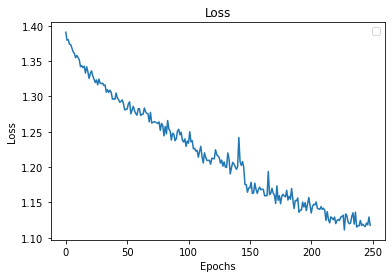

In [169]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


ax.plot(loss_list)
#ax.plot(b)

ax.set(xlabel="Epochs",ylabel="Loss")
ax.set(title ='Loss')
ax.legend()
#plt.savefig('figures/new/GraphConvtopk_bs64_lr002hc8k12_d5p01_loss.pdf')
plt.show()

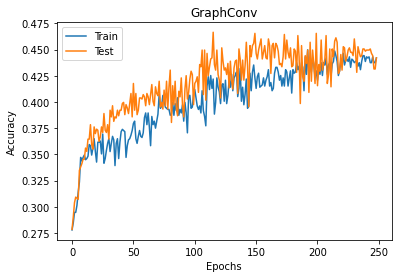

In [170]:
a = [train[0] for train in  train_list]
b = [train[1] for train in train_list]

length = np.zeros(len(train_list))
for ix in range(len(train_list)):
    length[ix] = ix

fig, ax = plt.subplots()
ax.plot(length,a,label='Train')
ax.plot(length,b,label='Test')
ax.set(xlabel="Epochs",ylabel="Accuracy")
ax.set(title ='GraphConv')
ax.legend()
#plt.savefig('figures/new/GraphConvtopk_bs64_lr002hc8k12_d5p01_test.pdf')
plt.show()